# Task 3: Piece Detection + Digital Twin

In [26]:
import matplotlib.pyplot as plt, numpy as np, os, torch, random, cv2, json
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision import models
from torchvision.transforms import v2 as transforms
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from PIL import Image
from ultralytics import YOLO
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
import torchvision.ops as ops
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, mean_squared_error

from src.our_chessboard_detection import read_image, apply_filters, get_contours, rotate_and_crop, align_board

random.seed(42)

# Dataset

## Load dataset

In [2]:
# Normalize images
data_aug = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_in = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

### Prep Dataset

In [3]:
def label_correct(id):
    return 0 if id == 12 else id + 1

i = 0
def label_correct_annotations(filepath):
    anns = json.load(open(filepath))
    for i in range(len(anns['categories'])):
        anns['categories'][i]['id'] = label_correct(anns['categories'][i]['id'])
    for i in range(len(anns['annotations']['pieces'])):
        anns['annotations']['pieces'][i]['category_id'] = label_correct(anns['annotations']['pieces'][i]['category_id'])
    
    fp = './chessred2k/label_corrected_annotations.json'
    with open(fp, 'w') as f:
        json.dump(anns, f)

label_correct_annotations('./chessred2k/annotations.json')

FileNotFoundError: [Errno 2] No such file or directory: './chessred2k/annotations.json'

### Original DSET

In [4]:
class ChessDataset(Dataset):
    def __init__(self, root_dir, partition, transform=None):
        self.root = root_dir
        self.anns = json.load(open(os.path.join(root_dir, 'label_corrected_annotations.json')))

        self.id_to_category = {c['id']: c['name'] for c in self.anns['categories']}
        self.category_to_id = {c['name']: c['id'] for c in self.anns['categories']}
        self.categories = [c['name'] for c in self.anns['categories']]

        # --- Step 1: Pre-process ALL annotations and identify problematic images ---
        self.all_image_ids_from_json = []
        self.all_file_names_from_json = []
        for img_info in self.anns['images']:
            self.all_file_names_from_json.append(img_info['path'])
            self.all_image_ids_from_json.append(img_info['id'])
        self.all_image_ids_from_json = np.asarray(self.all_image_ids_from_json) # Convert to numpy for easy indexing/masking

        problematic_image_ids = set() # Store image_ids that have any malformed piece annotation
        # This will store ONLY VALID annotations, grouped by image_id
        self.image_annotations = {}

        for ann_idx, ann in enumerate(self.anns['annotations']['pieces']):
            # Ensure required attributes for object detection are present
            if 'bbox' not in ann or 'category_id' not in ann:
                #print(f"Warning: Annotation at index {ann_idx} for image_id {ann.get('image_id', 'N/A')} is malformed (missing 'bbox' or 'category_id'). This image will be excluded.")
                if 'image_id' in ann:
                    problematic_image_ids.add(ann['image_id'])
                continue # Skip this malformed annotation

            image_id = ann['image_id']
            if image_id not in self.image_annotations:
                self.image_annotations[image_id] = []
            self.image_annotations[image_id].append(ann)


        # --- Step 2: Filter images based on split and problematic annotations ---
        if partition == 'train':
            raw_split_image_ids = np.asarray(self.anns['splits']['chessred2k']['train']['image_ids']).astype(int)
        elif partition == 'valid':
            raw_split_image_ids = np.asarray(self.anns['splits']['chessred2k']['val']['image_ids']).astype(int)
        else: # 'test'
            raw_split_image_ids = np.asarray(self.anns['splits']['chessred2k']['test']['image_ids']).astype(int)

        self.file_names = [] # Final list of file names for this split
        self.image_ids = []  # Final list of original image IDs for this split

        # Iterate through all images (which you already have indexed by self.all_image_ids_from_json)
        for i, img_id in enumerate(self.all_image_ids_from_json):
            # Check if image belongs to current split AND is not marked as problematic
            if img_id in raw_split_image_ids and img_id not in problematic_image_ids:
                # Also, ensure that the image actually has valid annotations after filtering.
                # An image could be in the split, not problematic, but simply have no pieces.
                # Or all its pieces were problematic, so it has no valid annotations left.
                if img_id in self.image_annotations and len(self.image_annotations[img_id]) > 0:
                    self.image_ids.append(img_id)
                    self.file_names.append(self.all_file_names_from_json[i])
                else:
                    # Optional: Print why an image might be excluded if it's in the split but has no valid annotations
                    print(f"Info: Image ID {img_id} (file: {self.all_file_names_from_json[i]}) in '{partition}' split has no valid annotations after initial filtering. Excluding.")

        self.file_names = np.asarray(self.file_names)
        self.image_ids = np.asarray(self.image_ids)

        self.transform = transform

        print(f"Number of {partition} images: {len(self.file_names)}")


    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        image_path = os.path.join(self.root, self.file_names[idx])
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        original_image_id = self.image_ids[idx] # Get the true original ID for this image in the split
        # Retrieve annotations using the pre-processed dictionary
        annotations_for_image = self.image_annotations.get(original_image_id, [])

        boxes = []
        labels = []

        # Iterate through the (already filtered and valid) annotations for this image
        for ann in annotations_for_image:
            x_min, y_min, width, height = ann['bbox']
            x_max = x_min + width
            y_max = y_min + height
            boxes.append([x_min, y_min, x_max, y_max])
            labels.append(ann['category_id'])

        # Convert to PyTorch tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32) if len(boxes) > 0 else torch.zeros((0, 4), dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64) if len(labels) > 0 else torch.zeros((0,), dtype=torch.int64)

        # Create the target dictionary required by Faster R-CNN
        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([original_image_id])
        }

        if self.transform:
            image = self.transform(image)

        return image, target

train_dataset = ChessDataset('./chessred2k', 'train', data_aug)
valid_dataset = ChessDataset('./chessred2k', 'valid', data_in)
test_dataset = ChessDataset('./chessred2k', 'test', data_in)

FileNotFoundError: [Errno 2] No such file or directory: './chessred2k/label_corrected_annotations.json'

### Cheat DSET

In [11]:
def get_perspective_transform(src_pts):
    dst_pts = np.array([
        [OFFSET, OFFSET],
        [512-OFFSET, OFFSET],
        [512-OFFSET, 512-OFFSET],
        [OFFSET, 512-OFFSET]
    ], dtype=np.float32)
    M = cv2.getPerspectiveTransform(np.array(src_pts, dtype=np.float32), dst_pts)
    return M

def warp_boxes(boxes, M):
    if len(boxes) == 0:
        return torch.zeros((0, 4), dtype=torch.float32)
    warped = []
    for box in boxes:
        x1, y1, x2, y2 = box
        pts = np.array([
            [x1, y1],
            [x2, y1],
            [x2, y2],
            [x1, y2]
        ], dtype=np.float32).reshape(-1, 1, 2)
        warped_pts = cv2.perspectiveTransform(pts, M).reshape(-1, 2)
        x_min, y_min = np.min(warped_pts, axis=0)
        x_max, y_max = np.max(warped_pts, axis=0)
        warped.append([x_min, y_min, x_max, y_max])
    return warped

In [5]:
OFFSET = 50

class CheatDataset(Dataset):
    def __init__(self, root_dir, partition, transform=None, corners=False, warp=False, annotations_file='label_corrected_annotations.json'):
        self.root = root_dir
        self.anns = json.load(open(os.path.join(root_dir, annotations_file)))

        self.id_to_category = {c['id']: c['name'] for c in self.anns['categories']}
        self.category_to_id = {c['name']: c['id'] for c in self.anns['categories']}
        self.categories = [c['name'] for c in self.anns['categories']]
        self.corners_f = corners
        self.warp_f = warp 
        if self.corners_f:
            # Load corner annotations
            self.corners = {}
            for corner_data in self.anns['annotations']['corners']:
                self.corners[corner_data['image_id']] = [
                    corner_data['corners']['top_left'],
                    corner_data['corners']['top_right'],
                    corner_data['corners']['bottom_right'],
                    corner_data['corners']['bottom_left']
                ]

        self.all_image_ids_from_json = []
        self.all_file_names_from_json = []
        for img_info in self.anns['images']:
            self.all_file_names_from_json.append(img_info['path'])
            self.all_image_ids_from_json.append(img_info['id'])

        self.all_image_ids_from_json = np.asarray(self.all_image_ids_from_json)

        problematic_image_ids = set()
        self.image_annotations = {}

        for ann in self.anns['annotations']['pieces']:
            if 'bbox' not in ann or 'category_id' not in ann:
                if 'image_id' in ann:
                    problematic_image_ids.add(ann['image_id'])
                continue
            image_id = ann['image_id']
            if image_id not in self.image_annotations:
                self.image_annotations[image_id] = []
            self.image_annotations[image_id].append(ann)

        if partition == 'train':
            raw_split_image_ids = np.asarray(self.anns['splits']['chessred2k']['train']['image_ids']).astype(int)
        elif partition == 'valid':
            raw_split_image_ids = np.asarray(self.anns['splits']['chessred2k']['val']['image_ids']).astype(int)
        else:
            raw_split_image_ids = np.asarray(self.anns['splits']['chessred2k']['test']['image_ids']).astype(int)

        self.file_names = []
        self.image_ids = []

        for i, img_id in enumerate(self.all_image_ids_from_json):
            if img_id in raw_split_image_ids and img_id not in problematic_image_ids:
                if img_id in self.image_annotations and len(self.image_annotations[img_id]) > 0:
                    if self.corners_f:
                        if img_id in self.corners:  # only keep if corner data is available
                            self.image_ids.append(img_id)
                            self.file_names.append(self.all_file_names_from_json[i])
                    else:
                        self.image_ids.append(img_id)
                        self.file_names.append(self.all_file_names_from_json[i])
        self.file_names = np.asarray(self.file_names)
        self.image_ids = np.asarray(self.image_ids)
        self.transform = transform

        print(f"Number of {partition} images: {len(self.file_names)}")

    def __len__(self):
        return len(self.file_names)

    def get_corners(self, idx):
        if self.corners_f:
            image_id = self.image_ids[idx]
            corners = self.corners[image_id]
            return corners

    def __getitem__(self, idx):
        image_path = os.path.join(self.root, self.file_names[idx])
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        image_id = self.image_ids[idx]
        boxes = []
        labels = []

        for ann in self.image_annotations[image_id]:
            x, y, w, h = ann['bbox']
            boxes.append([x, y, x + w, y + h])
            labels.append(ann['category_id'])

        if self.corners_f and self.warp_f:
            corners = self.corners[image_id]
            M = get_perspective_transform(corners)
            image = cv2.warpPerspective(image, M, (512, 512))
            boxes = warp_boxes(boxes, M)

        target = {
            "boxes": torch.tensor(boxes, dtype=torch.float32),
            "labels": torch.tensor(labels, dtype=torch.int64),
            "image_id": torch.tensor([image_id])
        }

        if self.transform:
                image = self.transform(image)

        return image, target


In [6]:
train_dataset = CheatDataset('', 'train', data_aug, corners=True, warp=False, annotations_file='annotations.json')
valid_dataset = CheatDataset('', 'valid', data_in, corners=True, warp=False, annotations_file='annotations.json')
test_dataset = CheatDataset('', 'test', data_in, corners=True, warp=False, annotations_file='annotations.json')

Number of train images: 1442
Number of valid images: 330
Number of test images: 306


## Actual Load

In [7]:
# Device configuration (improved version)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

# Hyperparameters (consider these adjustments)
batch_size = 8  # Reduced from 16 for better memory management with Faster R-CNN
num_workers = 0  # Optimal for most systems

def collate_fn(batch):
    """
    Enhanced collate function for object detection.
    Handles:
    - Empty targets
    - Image tensor conversion
    - Device movement
    """
    images, targets = zip(*batch)
    
    processed_images = []
    processed_targets = []
    
    for image, target in zip(images, targets):
        # Convert image if not already a tensor
        if not isinstance(image, torch.Tensor):
            image = transforms.ToTensor()(image)
        
        # Handle empty targets
        if len(target['boxes']) == 0:
            target['boxes'] = torch.zeros((0, 4), dtype=torch.float32)
            target['labels'] = torch.zeros((0,), dtype=torch.int64)
        else:
            assert target['boxes'].shape[1] == 4, "Bounding boxes must have shape [N, 4]"
            
        processed_images.append(image)
        processed_targets.append(target)
    
    return processed_images, processed_targets

# DataLoaders with improved settings
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    collate_fn=collate_fn,
    pin_memory=True if device.type == 'cuda' else False,
    drop_last=True  # Prevents partial batches
)

valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    collate_fn=collate_fn,
    pin_memory=True if device.type == 'cuda' else False,
    drop_last=True  # Keep all validation samples
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=1,  # Often better to use batch_size=1 for testing
    shuffle=True,
    num_workers=num_workers,
    collate_fn=collate_fn,
    pin_memory=True if device.type == 'cuda' else False,
    drop_last=True
)

Using cpu device


### Dataset Checks

In [ ]:
for i, (images, targets) in enumerate(valid_dataloader):
    print(f"\nBatch {i}:")
    for j, t in enumerate(targets):
        print(f"  Target {j}:")
        print(f"    Boxes shape: {t['boxes'].shape}")
        print(f"    Labels shape: {t['labels'].shape}")
        if t['boxes'].shape[0] != t['labels'].shape[0]:
            print("    Inconsistency!")
    
    if i >= 4:
        break

In [ ]:
#checking if the dataset is loaded correctly
for i in range(len(valid_dataset)):
    _, target = valid_dataset[i]
    assert target['boxes'].dim() == 2 and target['boxes'].shape[1] == 4

In [ ]:
# validating dataset with pieces

def plot_boxes(image, boxes, title="Detections"):
    plt.imshow(image)
    for box in boxes:
        x1, y1, x2, y2 = box
        rect = patches.Rectangle(
            (x1, y1), x2-x1, y2-y1,
            linewidth=2, edgecolor='r', facecolor='none'
        )
        plt.gca().add_patch(rect)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Ejemplo de uso con tus datos:
image, target = train_dataset[1]
denorm_img = (image * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)) + \
             torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
denorm_img = denorm_img.permute(1, 2, 0).cpu().numpy()
denorm_img = np.clip(denorm_img, 0, 1)

plot_boxes(denorm_img, target['boxes'], "Ground Truth")

# FasterRCNN

In [ ]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")



model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    

num_classes = 13  # 12 pieces + empty space
    

in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.to(device)


In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

learning_rate = 0.005
momentum = 0.9
weight_decay = 0.0005
step_size = 3 
gamma = 0.1

# Optimizador y scheduler
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=learning_rate, 
                     momentum=momentum, 
                     weight_decay=weight_decay)
lr_scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

### Train Model

In [ ]:
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()
    total_loss = 0
    loss_classifier = 0
    loss_box_reg = 0
    loss_objectness = 0
    loss_rpn_box_reg = 0
    
    progress_bar = tqdm(data_loader, desc=f'Epoch {epoch}')
    
    for images, targets in progress_bar:
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        total_loss += losses.item()
        loss_classifier += loss_dict.get('loss_classifier', 0).item()
        loss_box_reg += loss_dict.get('loss_box_reg', 0).item()
        loss_objectness += loss_dict.get('loss_objectness', 0).item()
        loss_rpn_box_reg += loss_dict.get('loss_rpn_box_reg', 0).item()
        
        progress_bar.set_postfix({
            'Loss': total_loss/(progress_bar.n+1),
            'Cls': loss_classifier/(progress_bar.n+1),
            'Box': loss_box_reg/(progress_bar.n+1)
        })
    
    return total_loss / len(data_loader)

In [ ]:
@torch.no_grad()
def evaluate(model, data_loader, device):
    model.train()
    total_loss = 0.0
    processed_batches = 0
    
    # Configuración especial para evitar errores de dimensiones
    original_score_thresh = model.roi_heads.score_thresh
    model.roi_heads.score_thresh = 0.0  # Desactiva filtrado inicial
    
    for batch_idx, (images, targets) in enumerate(tqdm(data_loader, desc='Validating')):
        # 1. Conversión explícita y verificación
        images = [img.to(device) for img in images]
        targets = [{
            'boxes': t['boxes'].float().to(device),
            'labels': t['labels'].long().to(device)
        } for t in targets]
        
        # 3. Forward pass con manejo de excepciones interno
        loss_dict = model(images, targets)
        
        # 4. Cálculo de pérdida unificado
        if isinstance(loss_dict, dict):
            losses = sum(loss for loss in loss_dict.values())
        else:  # Caso raro de lista de diccionarios
            losses = sum(sum(l.values()) for l in loss_dict)
        
        total_loss += losses
        processed_batches += 1
                
    
    # Restaura configuración original
    model.roi_heads.score_thresh = original_score_thresh

    return total_loss / processed_batches

In [ ]:
num_epochs = 3

def train_model(model, optimizer, lr_scheduler, train_dataloader, valid_dataloader, device, num_epochs, model_path, early_stop_patience=3):
    best_val_loss = float('inf')
    patience_counter = 0
    for epoch in range(num_epochs):
        # Entrenamiento
        train_loss = train_one_epoch(model, optimizer, train_dataloader, device, epoch)
        
        # Validación
        val_loss = evaluate(model, valid_dataloader, device)
        lr_scheduler.step()
        
        # Guardar mejor modelo
        if val_loss <= best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), model_path)
            patience_counter = 0
            print(f"¡Nuevo mejor modelo guardado! (val_loss: {val_loss:.4f})")
        else:
            patience_counter += 1
            if patience_counter >= early_stop_patience:
                print(f"Early stopping en epoch {epoch+1}")
                break
        
        # Log de progreso
        print(f"Epoch {epoch+1}/{num_epochs} | "
            f"Train Loss: {train_loss:.4f} | "
            f"Val Loss: {val_loss:.4f} | "
            f"LR: {optimizer.param_groups[0]['lr']:.6f}")
        print("-" * 60)

    print("¡Entrenamiento completado!")

In [ ]:
train_model(model, optimizer, lr_scheduler, train_dataloader, valid_dataloader, device, num_epochs, '13classes_warped.pth')

## Load Model

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, 13)
# Cargar mejor modelo
model.load_state_dict(torch.load('13classes_base.pth', map_location=device))
model.to(device)

## Evaluate Model

In [ ]:
def custom_nms(predictions, iou_threshold=0.5):
    filtered_preds = []

    for pred in predictions:
        boxes = pred['boxes']
        scores = pred['scores']
        labels = pred['labels']

        if boxes.numel() == 0:
            filtered_preds.append(pred)
            continue

        # Apply NMS with no pre-filtering
        keep_idxs = ops.nms(boxes, scores, iou_threshold=iou_threshold)

        # Keep only those selected by NMS
        filtered_preds.append({
            'boxes': boxes[keep_idxs],
            'scores': scores[keep_idxs],
            'labels': labels[keep_idxs]
        })

    return filtered_preds

def plot_prediction(model, image, target, debug=False):
    img_tensor = image.unsqueeze(0).to(device)
        
    with torch.no_grad():
        prediction = model(img_tensor)
    
    # Procesamiento de la imagen para visualización
    denorm_img = (image * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)) + \
                    torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    denorm_img = denorm_img.permute(1, 2, 0).cpu().numpy()
    denorm_img = np.clip(denorm_img, 0, 1)
    
    # Visualizar
    fig, ax = plt.subplots(1, 3, figsize=(15, 7))
    
    # Ground Truth
    ax[0].imshow(denorm_img)
    for box in target['boxes']:
        x1, y1, x2, y2 = box
        rect = patches.Rectangle(
            (x1, y1), x2-x1, y2-y1,
            linewidth=1, edgecolor='g', facecolor='none'
        )
        ax[0].add_patch(rect)
    ax[0].set_title('Ground Truth')
    ax[0].axis('off')

    ax[1].imshow(denorm_img) 
    for box in prediction[0]['boxes']:
        x1, y1, x2, y2 = box.tolist()
        rect = patches.Rectangle(
            (x1, y1), x2-x1, y2-y1,
            linewidth=1, edgecolor='r', facecolor='none'
        )
        ax[1].add_patch(rect)
    ax[1].set_title('Predictions')
    ax[1].axis('off')
    
    # Predicciones
    ax[2].imshow(denorm_img)

    filtered_preds = custom_nms(prediction)   
    for box in filtered_preds[0]['boxes']:
        x1, y1, x2, y2 = box.tolist()
        rect = patches.Rectangle(
            (x1, y1), x2-x1, y2-y1,
            linewidth=1, edgecolor='r', facecolor='none'
        )
        ax[2].add_patch(rect)
    ax[2].set_title('Predictions')
    ax[2].axis('off')
    
    plt.show()

def plot_predictions(model, dataset, num_samples=3):
    model.eval()
    indices = random.sample(range(len(dataset)), num_samples)
    
    for idx in indices:
        image, target = dataset[idx]
        plot_prediction(model, image, target)
        



In [ ]:
plot_predictions(model, test_dataset, num_samples=1)

In [ ]:
def test_model(model, device, data_loader, iou_threshold=0.5):
    model.eval()

    all_preds = []
    all_targets = []

    total_mse = 0.0
    matched_count = 0
    total_fp = 0
    total_fn = 0

    with torch.no_grad():
        for images, targets in tqdm(data_loader, desc='Testing'):
            images = [img.to(device) for img in images]
            targets = [{
                'boxes': t['boxes'].float().to(device),
                'labels': t['labels'].long().to(device)
            } for t in targets]

            predictions = model(images)

            for pred, gt in zip(predictions, targets):
                pred_boxes = pred['boxes']
                pred_labels = pred['labels']
                pred_scores = pred['scores']

                gt_boxes = gt['boxes']
                gt_labels = gt['labels']

                if pred_boxes.numel() == 0:
                    # No predictions — all GTs are false negatives
                    all_targets.extend(gt_labels.cpu().tolist())
                    all_preds.extend([-1] * len(gt_labels))  # -1 = no prediction
                    total_fn += len(gt_labels)
                    continue

                if gt_boxes.numel() == 0:
                    # No GT — all predictions are false positives
                    all_targets.extend([-1] * len(pred_labels))
                    all_preds.extend(pred_labels.cpu().tolist())
                    total_fp += len(pred_labels)
                    continue

                ious = ops.box_iou(gt_boxes, pred_boxes)  # [num_gt, num_pred]
                gt_matched = set()
                pred_matched = set()

                for gt_idx in range(len(gt_boxes)):
                    iou_row = ious[gt_idx]
                    max_iou, pred_idx = torch.max(iou_row, dim=0)

                    if max_iou >= iou_threshold and pred_idx.item() not in pred_matched:
                        # Match found
                        gt_label = gt_labels[gt_idx].item()
                        pred_label = pred_labels[pred_idx].item()

                        all_targets.append(gt_label)
                        all_preds.append(pred_label)

                        # Bounding box MSE
                        mse = F.mse_loss(
                            pred_boxes[pred_idx],
                            gt_boxes[gt_idx],
                            reduction='mean'
                        ).item()
                        total_mse += mse
                        matched_count += 1

                        gt_matched.add(gt_idx)
                        pred_matched.add(pred_idx.item())
                    else:
                        # No good match found
                        continue

                # Count false negatives (GTs not matched)
                for gt_idx in range(len(gt_boxes)):
                    if gt_idx not in gt_matched:
                        all_targets.append(gt_labels[gt_idx].item())
                        all_preds.append(-1)
                        total_fn += 1

                # Count false positives (preds not matched)
                for pred_idx in range(len(pred_boxes)):
                    if pred_idx not in pred_matched:
                        all_targets.append(-1)
                        all_preds.append(pred_labels[pred_idx].item())
                        total_fp += 1

    # Filter out unmatched (-1) before computing classification metrics
    y_true = torch.tensor([t for t in all_targets if t != -1])
    y_pred = torch.tensor([p for t, p in zip(all_targets, all_preds) if t != -1])
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    avg_mse = total_mse / matched_count if matched_count > 0 else float('inf')

    print(f"\nAccuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"MSE (boxes): {avg_mse:.4f}")

    return accuracy, precision, recall, f1, avg_mse

In [ ]:
# Without Board extraction preprocessing
test_model(model, device, test_dataloader)

In [ ]:
# With
test_model(model, device, test_dataloader)

# Yolo

### preprocesing dataset to turn it into YOLO format

In [ ]:
def convert_to_yolo_dataset(
    root_dir,
    output_dir='yolo_dataset'
):
    # load anotation
    annotations_path = os.path.join(root_dir, 'annotations.json')
    with open(annotations_path) as f:
        anns = json.load(f)
    
    # yolo folder firectory
    output_dir = Path(output_dir)
    (output_dir / 'train' / 'images').mkdir(parents=True, exist_ok=True)
    (output_dir / 'train' / 'labels').mkdir(parents=True, exist_ok=True)
    (output_dir / 'val' / 'images').mkdir(parents=True, exist_ok=True)
    (output_dir / 'val' / 'labels').mkdir(parents=True, exist_ok=True)
    (output_dir / 'test' / 'images').mkdir(parents=True, exist_ok=True)
    (output_dir / 'test' / 'labels').mkdir(parents=True, exist_ok=True)
    
    # check images id
    image_info = {img['id']: img for img in anns['images']}
    
    # get splits from original dataset
    splits = anns['splits']['chessred2k']
    train_ids = set(splits['train']['image_ids'])
    val_ids = set(splits['val']['image_ids'])
    test_ids = set(splits['test']['image_ids'])
    
    # process each image
    for img_id, img_data in image_info.items():
        # determine split
        if img_id in train_ids:
            split = 'train'
        elif img_id in val_ids:
            split = 'val'
        elif img_id in test_ids:
            split = 'test'
        else:
            continue
        
        # origin and destination paths
        src_img_path = os.path.join(root_dir, img_data['path'])
        dst_img_dir = output_dir / split / 'images'
        dst_label_dir = output_dir / split / 'labels'
        
        # copy image to the appropriate directory
        shutil.copy(src_img_path, dst_img_dir)
        
        # generate label file name and path
        img_width = img_data['width']
        img_height = img_data['height']
        txt_filename = Path(img_data['path']).stem + '.txt'
        txt_path = dst_label_dir / txt_filename
        
        # annotations for the current image
        img_annotations = [a for a in anns['annotations']['pieces'] if a['image_id'] == img_id]
        
        with open(txt_path, 'w') as f:
            for ann in img_annotations:
                if 'bbox' not in ann or 'category_id' not in ann:
                    continue  # Invalid annotations
                
                yolo_class = ann['category_id']
                
                # normalizing bounding box coordinates
                x_min, y_min, width, height = ann['bbox']
                x_center = (x_min + width / 2) / img_width
                y_center = (y_min + height / 2) / img_height
                norm_width = width / img_width
                norm_height = height / img_height
                
                f.write(f"{yolo_class} {x_center:.6f} {y_center:.6f} {norm_width:.6f} {norm_height:.6f}\n")
    
    yaml_content = f"""path: {output_dir.absolute()}
train: train/images
val: val/images
test: test/images

names:
0: white-pawn
1: white-rook
2: white-knight
3: white-bishop
4: white-queen
5: white-king
6: black-pawn
7: black-rook
8: black-knight
9: black-bishop
10: black-queen
11: black-king
12: empty
"""

    with open(output_dir / 'dataset.yaml', 'w') as f:
        f.write(yaml_content)

convert_to_yolo_dataset('')

### Defining the model

In [ ]:

model = YOLO("yolo11n.pt") 

results = model.train(data="yolo_dataset/dataset.yaml", 
                      epochs=100, imgsz=640, device="cpu", 
                      batch=8, project="chess_board_detection", 
                      name="yolo11n_run",
                      patience=10,
                      pretrained=True )



# Digital Twin

In [8]:
def predictions_to_board_matrix(boxes, labels, offset=20, board_size=512, squares=8):
    """
    Convert predicted bounding boxes and labels into an 8x8 board matrix,
    adjusting for homography offset padding.
    
    Parameters:
        boxes (Tensor or list of list): Nx4 format [[x1, y1, x2, y2], ...]
        labels (Tensor or list): length-N label list
        offset (int): pixel offset added during warp
        board_size (int): total size of the board image (typically 512)
        squares (int): number of squares per row/column (8 for standard chess)

    Returns:
        board_matrix: 8x8 numpy array with labels placed in appropriate squares
    """
    board = np.zeros((squares, squares), dtype=int) - 1
    square_size = (board_size - 2 * offset) / squares

    for box, label in zip(boxes, labels):
        x1, y1, x2, y2 = box
        cx = ((x1 + x2) / 2) - offset
        cy = ((y1 + y2) / 2) - offset

        col = int(cx // square_size)
        row = int(cy // square_size)

        # Clamp to stay within bounds
        col = max(0, min(squares - 1, col))
        row = max(0, min(squares - 1, row))

        board[row, col] = int(label)

    return board


image 1/1 /Users/santiagoromero/Documents/cv/-Detect_the_chess_board_and_chess_pieces/images/0/G000_IMG001.jpg: 640x640 8 white-pawns, 2 white-rooks, 3 white-knights, 2 white-bishops, 1 white-queen, 2 white-kings, 10 black-pawns, 2 black-rooks, 2 black-knights, 3 black-bishops, 2 black-queens, 1 black-king, 43.9ms
Speed: 1.9ms preprocess, 43.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Angle
0
Px Count
269
Angle
90
Px Count
208
Angle
180
Px Count
300
Angle
270
Px Count
898


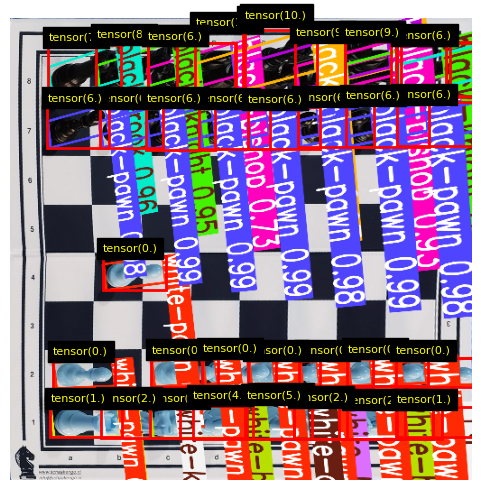

In [12]:
model = YOLO("chess_board_detection/yolo11n_run2/weights/best.pt")

image_path =os.path.join(test_dataset.root, test_dataset.file_names[1])
# Predecir en una imagen
results = model.predict(
    source=image_path
)


result = results[0]  # Get the first result
boxes = result.boxes.xyxy  # Coor [x1, y1, x2, y2]
labels = result.boxes.cls  # class id
confs = result.boxes.conf   # confidence scores

# Our board extraction
image = read_image(image_path, False)
filtered_images = apply_filters(image, False)
chess_contour = get_contours(filtered_images, show=False,  kernel_size=(25,25) ,  kernel_usage=True, iterations=4)
warped_image, M1 = rotate_and_crop(filtered_images, chess_contour[0][1], show=False)
rotated_image, M2 = align_board(warped_image, radius=12, angle_step=90, show=False)
M2_homography = np.vstack([M2, [0, 0, 1]])
M_combined = M2_homography @ M1


# === Warp image ===
warp_img = cv2.warpPerspective(result.plot(), M_combined, (512, 512))

warped_boxes = warp_boxes(boxes, M_combined)

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(warp_img)

for box, label in zip(warped_boxes, labels):
    x1, y1, x2, y2 = box
    rect = Rectangle((x1, y1), x2 - x1, y2 - y1,
                    linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)
    ax.text(x1, y1 - 5, str(label), color='yellow', fontsize=8, backgroundcolor='black')

plt.axis('off')
plt.show()

In [13]:
board = predictions_to_board_matrix(warped_boxes, labels, offset=45)
board

array([[ 7,  8,  6, -1, 10, 10,  9,  9],
       [ 6,  6,  6,  6,  6,  6, -1,  6],
       [-1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1],
       [-1,  0, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1],
       [ 0, -1,  0,  0,  0,  0, -1,  0],
       [ 1,  2, -1,  3,  4,  5,  2,  1]])

In [14]:

def render_chessboard(board_matrix, sprite_path, cell_size=80):
    """
    Renders a chessboard from a matrix and individual piece images.

    Args:
        board_matrix (np.ndarray): 8x8 matrix with -1 for empty and 0-11 for pieces.
        sprite_path (str): Directory containing PNG images for pieces.
        cell_size (int): Size of each square on the board in pixels.
    """
    # Create the output image
    board_img = np.ones((8 * cell_size, 8 * cell_size, 4), dtype=np.uint8) * 255

    # Load the piece images
    piece_images = {}
    for i in range(12):  # Pieces are indexed from 0 to 11
        file_path = os.path.join(sprite_path, f"{i}.png")
        if os.path.exists(file_path):
            piece_img = cv2.imread(file_path, cv2.IMREAD_UNCHANGED)  # Load with alpha channel
            piece_img = cv2.cvtColor(piece_img, cv2.COLOR_BGRA2RGBA)  # Convert to RGBA
            piece_images[i] = piece_img

    # Draw squares and pieces
    for row in range(8):
        for col in range(8):
            x0 = col * cell_size
            y0 = row * cell_size
            color = (240, 217, 181) if (row + col) % 2 == 0 else (181, 136, 99)
            board_img[y0:y0 + cell_size, x0:x0 + cell_size] = np.array(color + (255,), dtype=np.uint8)

            piece_id = board_matrix[row][col]
            if piece_id >= 0 and piece_id < 12:  # Ensure piece_id is valid
                piece_img = piece_images.get(piece_id, None)
                if piece_img is not None:
                    piece_img_resized = cv2.resize(piece_img, (cell_size, cell_size))

                    # Composite the piece image onto the board image
                    for c in range(4):  # Iterate over RGBA channels
                        board_img[y0:y0 + cell_size, x0:x0 + cell_size, c] = np.where(
                            piece_img_resized[:, :, 3] > 0,  # Check if the alpha channel is not zero
                            piece_img_resized[:, :, c],      # Use the piece image
                            board_img[y0:y0 + cell_size, x0:x0 + cell_size, c]  # Keep the background
                        )

    # Convert to RGB for displaying with Matplotlib
    board_img = cv2.cvtColor(board_img, cv2.COLOR_RGBA2RGB)
    plt.imshow(board_img)
    plt.axis('off')  # Hide axes
    plt.show()

    return board_img

In [ ]:
img = render_chessboard(board, "./chess_piece_sprites")

### Evaluate the model

In [54]:
model = YOLO("chess_board_detection/yolo11n_run2/weights/best.pt")
results = model.predict(
    source=image_path
)



image 1/1 /Users/santiagoromero/Documents/cv/-Detect_the_chess_board_and_chess_pieces/images/0/G000_IMG001.jpg: 640x640 8 white-pawns, 2 white-rooks, 3 white-knights, 2 white-bishops, 1 white-queen, 2 white-kings, 10 black-pawns, 2 black-rooks, 2 black-knights, 3 black-bishops, 2 black-queens, 1 black-king, 46.1ms
Speed: 1.9ms preprocess, 46.1ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


In [55]:
def compute_iou(box1, box2):
    x_left = max(box1[0], box2[0])
    y_top = max(box1[1], box2[1])
    x_right = min(box1[2], box2[2])
    y_bottom = min(box1[3], box2[3])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    iou = intersection_area / float(box1_area + box2_area - intersection_area)
    return iou


In [ ]:
def plot_precision_recall(precisions, recalls):
    plt.figure(figsize=(8, 6))
    plt.plot(recalls, precisions, marker='o')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.grid()
    plt.show()

In [58]:
def plot_iou_distribution(iou_scores):
    plt.figure(figsize=(8, 6))
    plt.hist(iou_scores, bins=30, range=(0, 1), color='skyblue', edgecolor='black')
    plt.xlabel('IoU')
    plt.ylabel('Frequency')
    plt.title('IoU Distribution')
    plt.grid()
    plt.show()


In [60]:
import matplotlib.pyplot as plt

def evaluate_yolo_with_iou_and_collect(model, dataset, iou_threshold=0.5, conf_threshold=0.5):
    total_tp = 0
    total_fp = 0
    total_fn = 0

    iou_scores = []
    precisions = []
    recalls = []

    for i in tqdm(range(len(dataset))):
        image_path = os.path.join(dataset.root, dataset.file_names[i])
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        image_id = dataset.image_ids[i]
        gt_boxes = []
        gt_labels = []

        for ann in dataset.image_annotations[image_id]:
            x, y, w, h = ann['bbox']
            gt_boxes.append([x, y, x + w, y + h])
            gt_labels.append(ann['category_id'])

        if len(gt_boxes) == 0:
            continue

        results = model.predict(image, conf=conf_threshold, verbose=False)
        predictions = results[0]

        if predictions.boxes is None or len(predictions.boxes.data) == 0:
            total_fn += len(gt_boxes)
            continue

        pred_boxes = predictions.boxes.xyxy.cpu().numpy()
        pred_labels = predictions.boxes.cls.cpu().numpy().astype(int)

        matched_gt = set()
        tp = 0
        fp = 0

        for pred_box in pred_boxes:
            matched = False
            best_iou = 0
            for idx, gt_box in enumerate(gt_boxes):
                if idx in matched_gt:
                    continue

                iou = compute_iou(pred_box, gt_box)
                if iou >= iou_threshold and iou > best_iou:
                    best_iou = iou
                    best_match = idx

            if best_iou >= iou_threshold:
                tp += 1
                matched_gt.add(best_match)
                iou_scores.append(best_iou)
                matched = True
            else:
                fp += 1
                iou_scores.append(0)

        fn = len(gt_boxes) - len(matched_gt)

        total_tp += tp
        total_fp += fp
        total_fn += fn

        precision = total_tp / (total_tp + total_fp + 1e-6)
        recall = total_tp / (total_tp + total_fn + 1e-6)

        precisions.append(precision)
        recalls.append(recall)

    final_precision = total_tp / (total_tp + total_fp + 1e-6)
    final_recall = total_tp / (total_tp + total_fn + 1e-6)
    f1 = 2 * (final_precision * final_recall) / (final_precision + final_recall + 1e-6)

    print(f"Precision: {final_precision:.4f}")
    print(f"Recall: {final_recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    return precisions, recalls, iou_scores


100%|██████████| 306/306 [00:20<00:00, 14.99it/s]

Precision: 0.9404
Recall: 0.9469
F1 Score: 0.9436


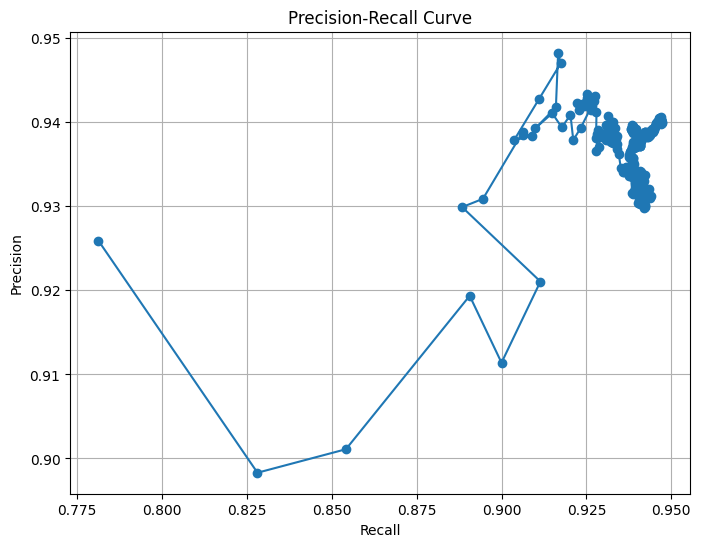

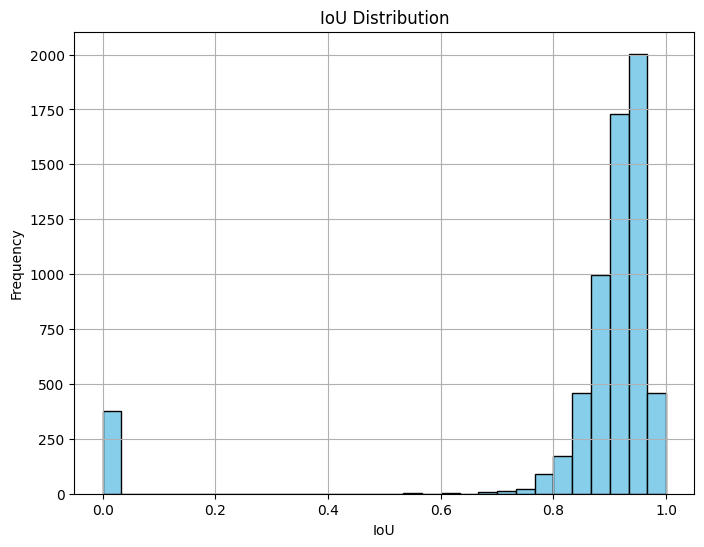

In [61]:
precisions, recalls, iou_scores = evaluate_yolo_with_iou_and_collect(model, test_dataset)

plot_precision_recall(precisions, recalls)
plot_iou_distribution(iou_scores)